<b>Описание проекта</b>

Вам даны данные о возрасте, в котором умирали европейцы в середине 19 века в зависимости от их класса: sovereignty (sovr), aristocracy (aris), gentry (gent)).

https://gist.github.com/StMrKirk/a4b9ee93f5149bf8e2ba14d5e64c65d2

Необходимо проверить отличается ли длительность жизни между парами классов

<hr style='border: 1px solid'>

## 1. Подготовка к работе. Импорт библиотек и настройка параметров графиков

In [72]:
# Импортируем библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scikit_posthocs as sp
%matplotlib inline

In [2]:
# Подготавливаем общие настройки для графиков

sns.set(
rc={
    'figure.figsize':(46,20)
},
font_scale=2
)

<hr style='border: 1px solid'>

## 2. Загрузка и предварительный анализ данных

In [35]:
# Загружаем данные
# Поскольку данные раздлены разными пробелами, используем параметр delimeter и регуляряное выражение для разделения
# данных по столбцах по пробелам любых размеров + создаем сразу соответствующие названия столбцов

df = pd.read_csv('https://gist.githubusercontent.com/StMrKirk/a4b9ee93f5149bf8e2ba14d5e64c65d2/raw/f60699dfd43a0f1f59e1ebd6ef4e9cc4574f5a06/agedeath.txt', \
        delimiter=r"\s+",  names=['class','age','number']  )

In [36]:
df

,class,age,number
0,aris,21,1
1,aris,21,2
2,aris,21,3
3,aris,21,4
4,aris,21,5
...,...,...,...
6181,sovr,95,1436
6182,sovr,95,1437
6183,sovr,97,1438
6184,sovr,100,1439


In [37]:
# Порядковый номер каждого из класса нам не понадобится, так что удалим его

df.drop(columns='number', inplace=True)

In [38]:
df

,class,age
0,aris,21
1,aris,21
2,aris,21
3,aris,21
4,aris,21
...,...,...
6181,sovr,95
6182,sovr,95
6183,sovr,97
6184,sovr,100


In [39]:
# Проверяем данные на наличие пропусков

df.isna().sum()

class    0
age      0
dtype: int64

In [42]:
# Смотрим, сколько у нас данных в каждом из классов

groups = df.groupby('class', as_index=False) \
.agg({'age':'count'}) \
.rename(columns={'age':'people'})

In [43]:
groups

,class,people
0,aris,2291
1,gent,2455
2,sovr,1440


Видим, что выборки достаточно большие

In [44]:
# Смотрим, какой средний возраст в каждом классе

age_groups = df.groupby('class', as_index=False) \
.agg({'age':'mean'}) \
.rename(columns={'age':'average_age'})

In [45]:
age_groups

,class,average_age
0,aris,60.233522
1,gent,57.307943
2,sovr,54.232639


Видим, что у аристократов средний возраст выше, чем в остальных группах. Далее необходимо проверить, является ли данная разница стат. значимой

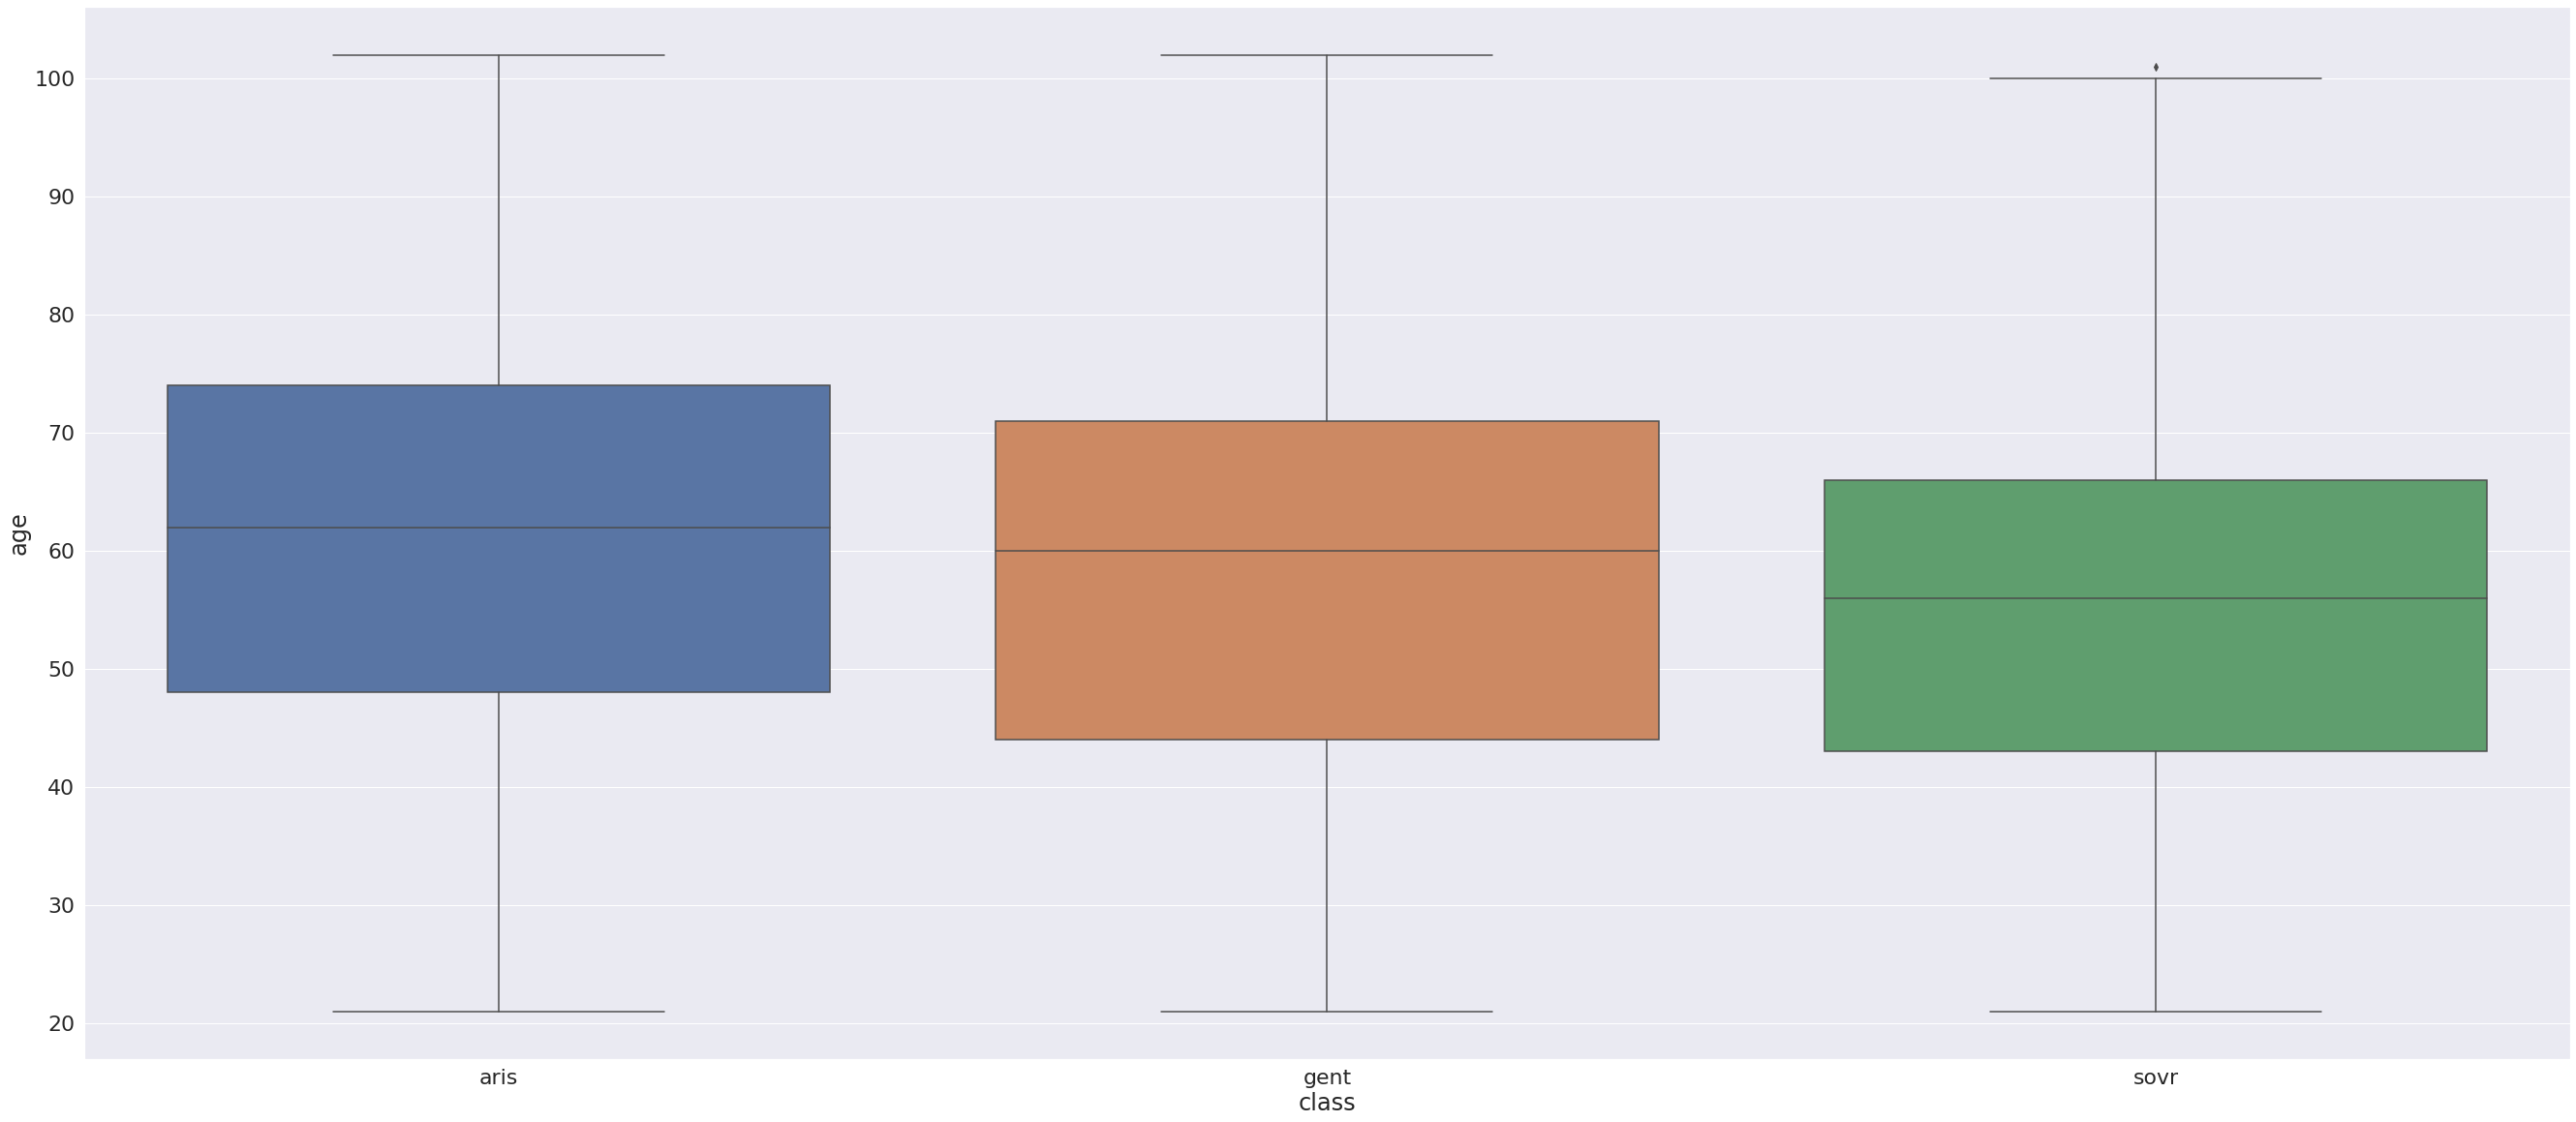

In [46]:
# Визуализируем распределения значений возраста во всех трех классах

sns.boxplot(data=df, y ='age', x='class')
plt.show()

Видим, что явных выбросов нет, очень похоже, что данные распределены нормально.

<hr style='border: 1px solid'>

## 3. Выбор и проведение теста. Формулирование вывода

Поскольку у нас три выборки, и исследуется влияние одного фактора (класса) на значение возраста, необходимо применить <u>однофакторный дисперсионный анализ</u> для проверки гипотезы о том, что между какими-то парами групп могут быть различия.
<br><br>
Для применения классическго параметрического дисперсионного анализа необходимо удостовериться, что между тремя группами есть гомогенность дисперсий. Критерий нормальности распределений не существенен, поскольку явных выбросов в данных нет + n > 30 в каждой выборке.

Создаем выборки с каждым классом

In [61]:
aris = df.loc[df['class'] == "aris"].age
gent = df.loc[df['class'] == "gent"].age
sovr = df.loc[df['class'] == "sovr"].age

In [64]:
# Используем тест Левена из библиотеки scipy stats для проверки гомогенности дисперсий

stats.levene(sovr,gent, aris, center='mean')

LeveneResult(statistic=16.64341253892409, pvalue=6.183650739692919e-08)

Видим, что p-value намного меньше 0.05, следовательно, дисперсии между группами не гомогенны.
<br>
Таким образом, мы не сможем применить классический параметрический дисперсионный анализ для сравнения средних.
<br><br>
Непараметрическим эквивалентом однофакторного дисперсионного анализа является критерий <b>Крускала-Уоллиса</b>.

Итак, для проверки наличия стат. значимых различий в возрасте между тремя классами нам необходимо применить критерий Крускала-Уоллиса.
<br><br>
<b>H0</b>: Медианное значение возраста одинаково для всех групп.
<br>
<b>H1</b>: Медианное значение возраста не одинаково для всех групп.
<br><br>
Уровень значимости устанавливаем в размере 0.05(5%).

In [66]:
# Поскольку будем проверять медианы, выведем медианные значения возрастам вместо среднего

age_groups = df.groupby('class', as_index=False) \
.agg({'age':'median'}) \
.rename(columns={'age':'median_age'})

In [67]:
age_groups

,class,median_age
0,aris,62
1,gent,60
2,sovr,56


In [65]:
# проведем тест Крускала-Уоллиса, используя функцию kruskal() из библиотеки scipy.stats

stats.kruskal(aris, gent, sovr)

KruskalResult(statistic=114.32458786643477, pvalue=1.495309773351765e-25)

<b>Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу о том, что средний возраст одинаков для всех трех классов. У нас есть достаточно доказательств, чтобы заключить, что класс влияет на продолжительность жизни.
<br><br>
Однако мы не знаем, между какими именно классами есть стат. значимые различия.
<br>
Для попарного сравнения применим критерий Данна.
</b>

In [73]:
# Создаем список из значений возрастов трех классов

ages = [aris, gent, sovr]

In [76]:
# Проводим тест с помощью метода posthoc_dunn библиотеки scikit_posthocs 
# с поправкой Бонферрони

p_values = sp.posthoc_dunn(ages, p_adjust = 'bonferroni')

In [77]:
print(p_values)

              1             2             3
1  1.000000e+00  2.052669e-07  4.255543e-26
2  2.052669e-07  1.000000e+00  3.433624e-09
3  4.255543e-26  3.433624e-09  1.000000e+00


Видим, что p-value для разницы между aris и gent - <b>2.052669e-07</b>.
<br>
P-value для разницы между gent и sovr - <b>3.433624e-09</b>.
<br>
P-value для разницы между aris и sovr - <b>4.255543e-26</b>.

<b>
    <u>Вывод по итогу теста</u>: между всеми тремя классами есть стат. значимые различия в показателях продолжительности жизни. Самая большя продолжительность жизни у аристократов.    
</b>